In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as sp

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from insurance_classifier.dataset import DataPreprocessor

2026-01-14 14:29:39.146 | INFO     | insurance_classifier.config:<module>:11 - PROJ_ROOT path is: /home/iury_unix/ml_projects/h_insurance_cs


# 0.0 Loading data

In [ ]:
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')

X = train.drop(['response'], axis=1)
y = train['response'].copy()

X_test = test.drop(['id'], axis=1)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

## 0.1 Helper Functions

In [79]:
def precision_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]   

    return np.mean(y_true.iloc[idx])

def recall_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]  

    return np.sum(y_true.iloc[idx]) / np.sum(y_true)

# Define @k scorers
precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=20000)
recall_at_k_scorer = make_scorer(recall_at_k, response_method='predict_proba', k=20000)


# 1.0 Linear Models

## 1.1. Default parameters

### 1.1.1 Loss function = hinge (Linear SVM)

In [51]:
# Model initialization
sgd_lin = SGDClassifier(loss='hinge')

# Predict probabilities
clf = CalibratedClassifierCV(sgd_lin)

# Train
clf.fit(X_train, y_train)

# Predict
y_hat_lin = clf.predict_proba(X_val)


### 1.1.2 Loss function = log-loss (Logistic Regression)

In [52]:
# Model initialization
sgd_log = SGDClassifier(loss='log_loss')

# Train
sgd_log.fit(X_train, y_train)

# Predict
y_hat_log = sgd_log.predict_proba(X_val)

## 1.2 Baseline Performance

In [80]:
# Linear SVM
precision_lin = precision_at_k(y_true=y_val, y_proba=y_hat_lin, k=20000)
recall_lin = recall_at_k(y_true=y_val, y_proba=y_hat_lin, k=20000)

# Log-loss
precision_log = precision_at_k(y_true=y_val, y_proba=y_hat_log, k=20000)
recall_log = recall_at_k(y_true=y_val, y_proba=y_hat_log, k=20000)

# Dataframe
results = pd.DataFrame({'Model': ['Linear SVM', 'logistic regression'],
                        '@k': [20000, 20000],
                        'Precision@k': [precision_lin, precision_log],
                        'Recall@k': [recall_lin, recall_log]})
results

,Model,@k,Precision@k,Recall@k
0,Linear SVM,20000,0.2989,0.642243
1,logistic regression,20000,0.2983,0.640954


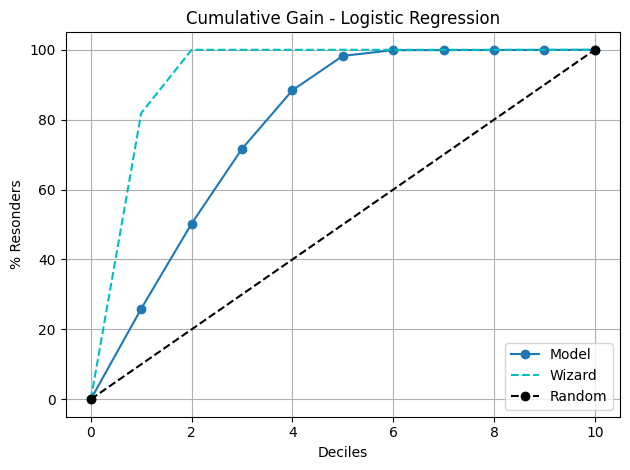

In [55]:
sp.kds.plot_cumulative_gain(y_val, y_hat_log[:,1], title='Cumulative Gain - Logistic Regression');

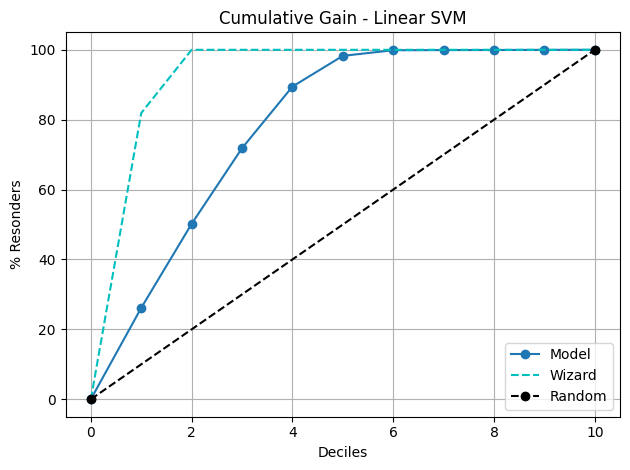

In [56]:
sp.kds.plot_cumulative_gain(y_val, y_hat_lin[:,1], title='Cumulative Gain - Linear SVM');

# 2.0 Non-linear Models

## 2.1. Default config

In [61]:
# model initialization
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X_train, y_train)

# Predict
knn_proba = knn.predict_proba(X_val)

## 2.2 Baseline Performance

In [63]:
# KNN
precision_knn = precision_at_k(y_true=y_val, y_proba=knn_proba, k=20000)
recall_knn = recall_at_k(y_true=y_val, y_proba=knn_proba, k=20000)

# Dataframe
results_knn = pd.DataFrame({'Model': ['KNN'],
                        '@k': 20000,
                        'Precision@k': precision_knn,
                        'Recall@k': recall_knn})
results_knn

,Model,@k,Precision@k,Recall@k
0,KNN,20000,0.27065,0.581543


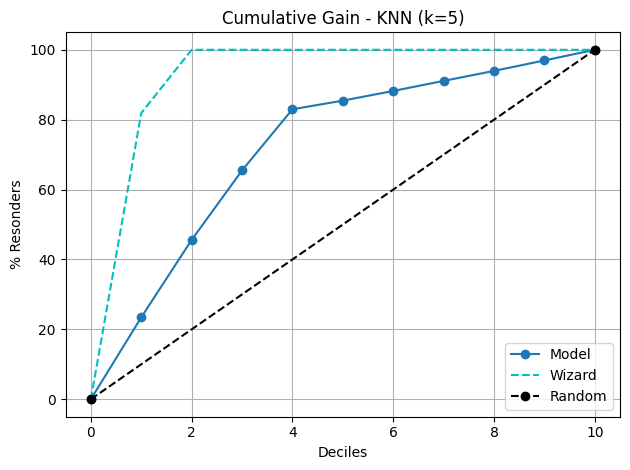

In [64]:
sp.kds.plot_cumulative_gain(y_val, knn_proba[:,1], title='Cumulative Gain - KNN (k=5)');

## 2.3. Cross validation 

In [81]:
# SGD Classifier with linear SVM
cross_val = cross_val_score(clf, X_train, y_train, cv=5, scoring=precision_at_k_scorer)
cross_val

array([0.2943 , 0.2873 , 0.2898 , 0.2936 , 0.29065])